# Diabetes prediction: decision tree

## Notebook set-up

In [1]:
# Python standard library imports
import pickle
from pathlib import Path
from itertools import combinations

# PyPI imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier

# Internal imports
import configuration as config
import functions as funcs

## 1. Data loading

### 1.1. Load data from URL

In [2]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
data_df  =pd.read_csv(url)
data_df.drop_duplicates().reset_index(drop=True, inplace=True)

### 1.2. Save a local copy

In [3]:
# Make a directory for raw data
Path('../data/raw').mkdir(exist_ok=True, parents=True)

# Save a local copy of the raw data
data_df.to_parquet('../data/raw/medical-insurance-cost.parquet')

### 1.3. Inspect

In [4]:
data_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 2. EDA
### 2.1. Data composition

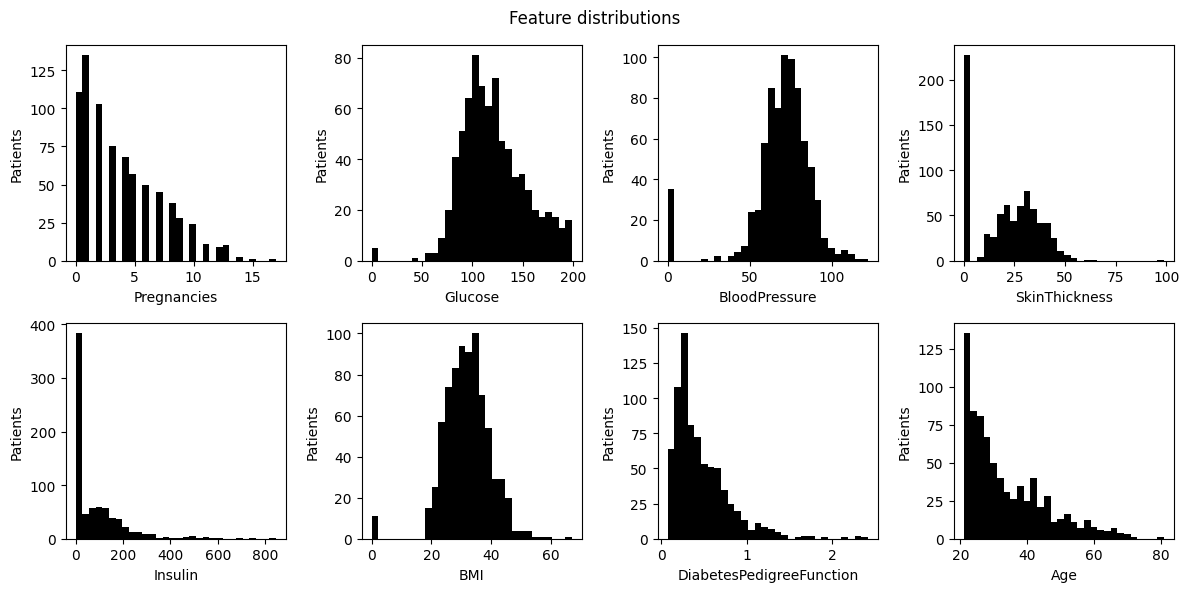

In [6]:
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
            'Insulin','BMI','DiabetesPedigreeFunction','Age']

fig, axs = plt.subplots(2,4, figsize=(12,6))
axs = axs.flatten()

fig.suptitle('Feature distributions')

for i, feature in enumerate(features):
    axs[i].hist(data_df[feature], color='black', bins=30)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Patients')

fig.tight_layout()

### 2.2. Feature interactions

#### 2.2.1. Feature cross-correlations

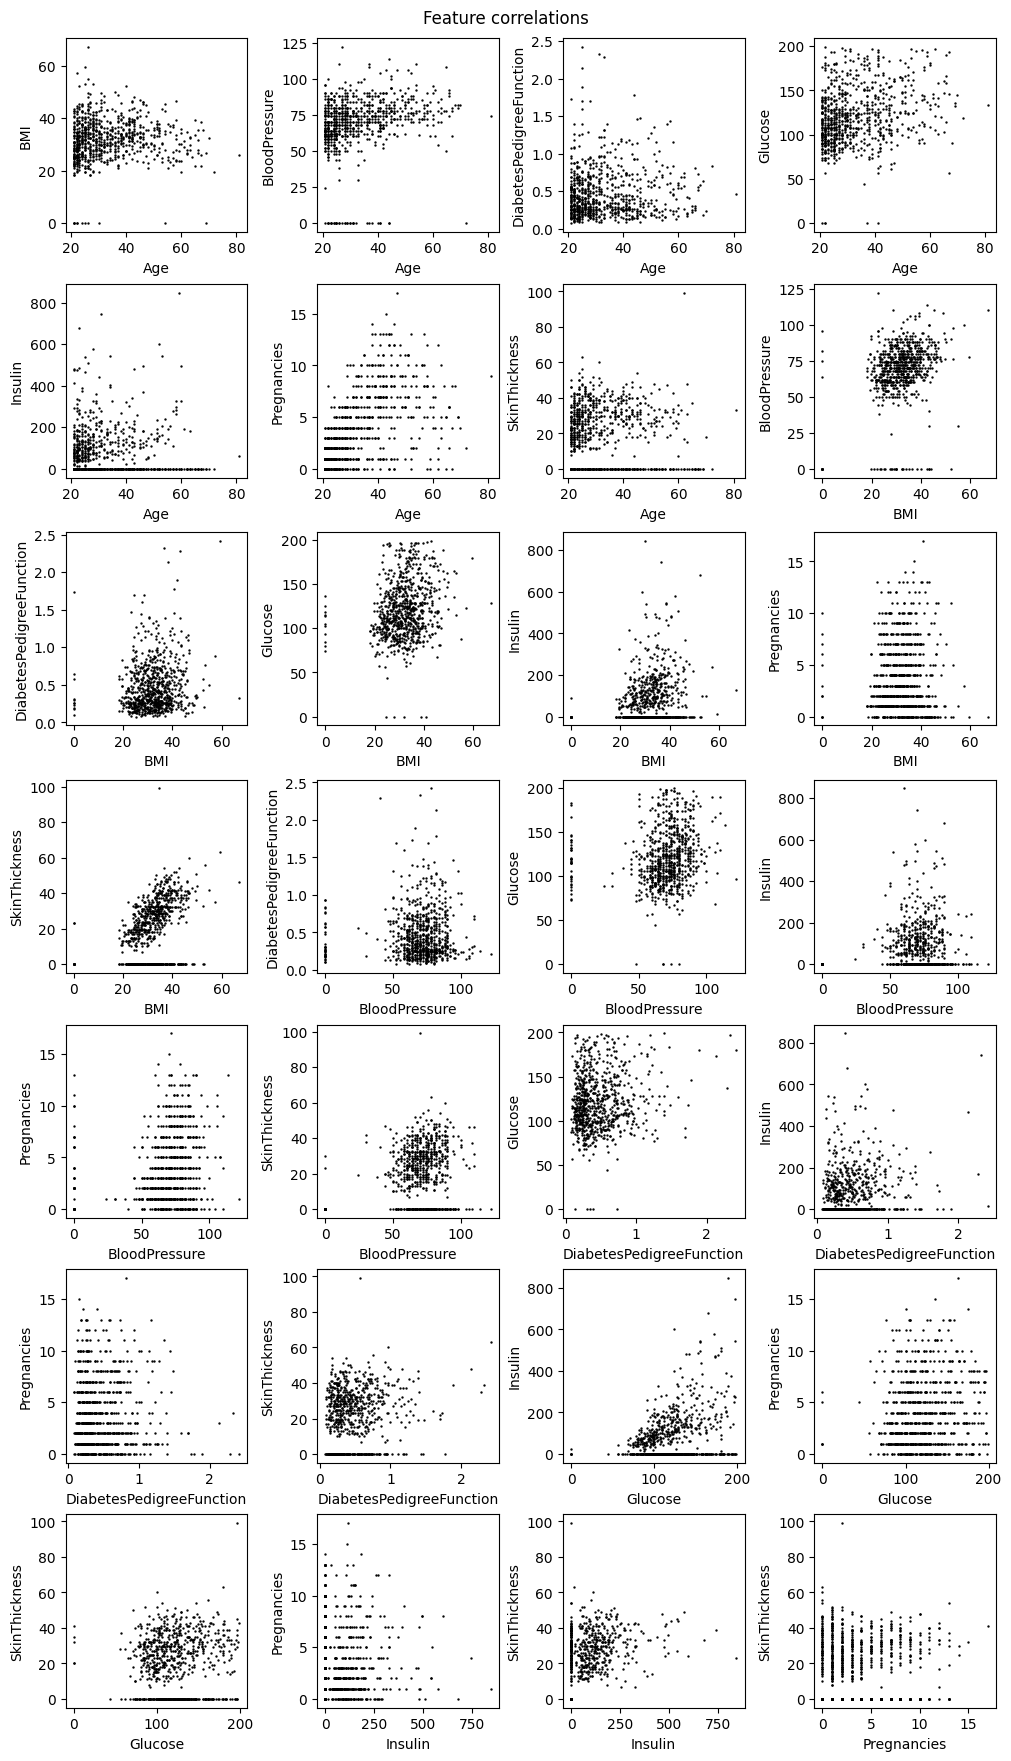

In [7]:
feature_pairs = sorted(map(sorted, combinations(set(features), 2)))
rows = len(feature_pairs) // 4

fig, axs = plt.subplots(rows,4, figsize=(10,rows*2.5), layout='constrained')
axs = axs.flatten()

fig.suptitle('Feature correlations')

for i, feature_pair in enumerate(feature_pairs):
    axs[i].scatter(data_df[feature_pair[0]], data_df[feature_pair[1]], color='black', s=0.5)
    axs[i].set_xlabel(feature_pair[0])
    axs[i].set_ylabel(feature_pair[1])

#### 2.2.2. Feature-label interactions

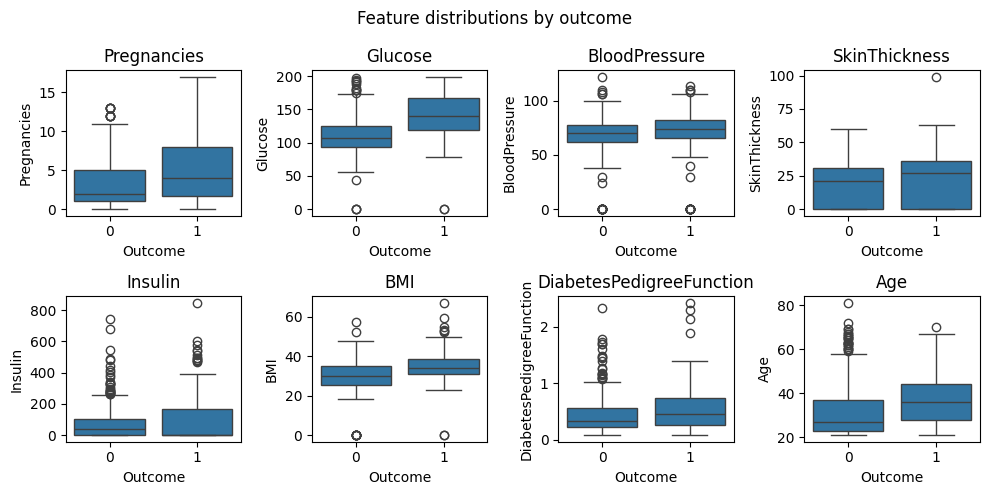

In [8]:
fig, axs = plt.subplots(2,4, figsize=(10,5))
axs = axs.flatten()

fig.suptitle('Feature distributions by outcome')

for i, feature in enumerate(features):

    sns.boxplot(data_df, x='Outcome', y=feature, ax=axs[i])
    axs[i].set_title(feature)

fig.tight_layout()

## 3. Data preparation

### 3.1. Test-train split

In [9]:
training_df, testing_df = train_test_split(
    data_df,
    test_size=0.30
)

print(f'Training set: {len(training_df)} rows')
print(f'Testing set: {len(testing_df)} rows')

Training set: 537 rows
Testing set: 231 rows


### 3.2. Imputation of zeros

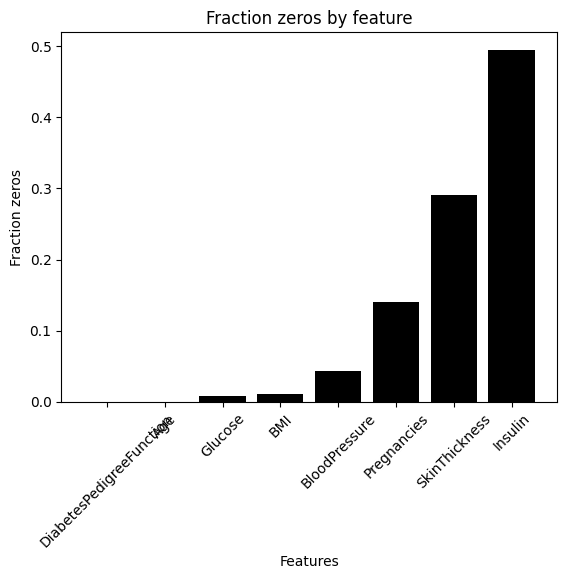

In [10]:
zero_fraction = (training_df[features] == 0).astype(int).sum(axis=0) / len(training_df)
zero_fraction.sort_values(inplace=True)

plt.title('Fraction zeros by feature')
plt.bar(zero_fraction.index, zero_fraction, color='black')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Fraction zeros')
plt.show()

In [11]:
imputed_features = ['Insulin','SkinThickness','BloodPressure','BMI','Glucose']
knn_imputer = KNNImputer(missing_values=0.0, weights='distance')
knn_imputer.fit(training_df[imputed_features])
training_df[imputed_features] = knn_imputer.transform(training_df[imputed_features])
testing_df[imputed_features] = knn_imputer.transform(testing_df[imputed_features])

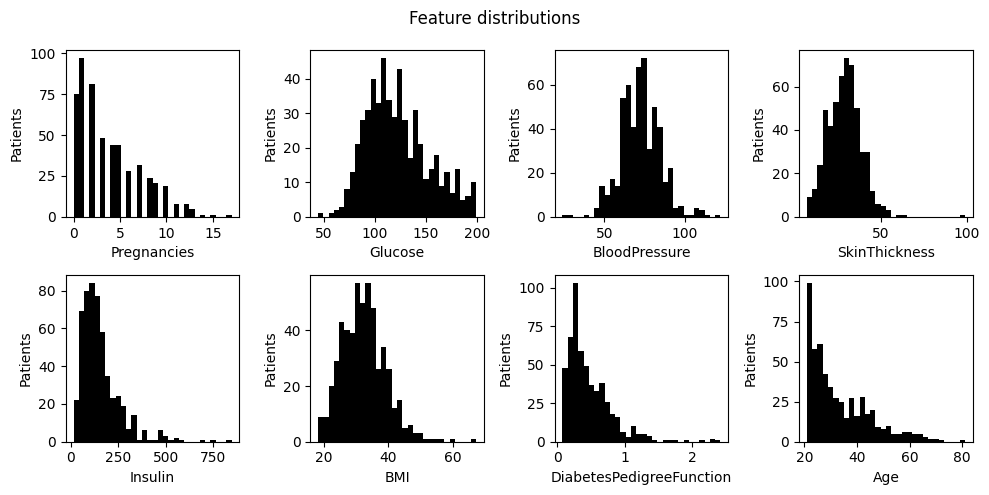

In [12]:
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
            'Insulin','BMI','DiabetesPedigreeFunction','Age']

fig, axs = plt.subplots(2,4, figsize=(10,5))
axs = axs.flatten()

fig.suptitle('Feature distributions')

for i, feature in enumerate(features):
    axs[i].hist(training_df[feature], color='black', bins=30)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Patients')

fig.tight_layout()

## 4. Model training

In [13]:
cross_val_scores = {
    'Model': [],
    'Score': []
}

### 4.1. Baseline

In [14]:
# Accuracy for constant '0' model
accuracy = ((len(training_df) - sum(training_df['Outcome'])) / len(training_df))*100
print(f'Training accuracy of constant "0" model: {accuracy:.1f}%')

Training accuracy of constant "0" model: 65.9%


In [15]:
model = LogisticRegression(max_iter=5000)
model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy = accuracy_score(model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Training accuracy of logistic regression model: {accuracy:.1f}%')

Training accuracy of logistic regression model: 77.8%


In [16]:
cross_val_scores = {
    'Model': [],
    'Score': []
}

scores = cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Logistic regression']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Logistic regression cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Logistic regression cross-validation accuracy: 77.5 +/- 3.0%


### 4.2. Decision tree classifier

In [17]:
model = DecisionTreeClassifier()
model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy = accuracy_score(model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Training accuracy of decision tree model: {accuracy:.1f}%')

Training accuracy of decision tree model: 100.0%


In [18]:
scores = cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Decision tree']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Decision tree cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Decision tree cross-validation accuracy: 66.9 +/- 3.7%


## 4. Hyperparameter optimization

### 4.1. Hyperparameter random search

In [27]:
hyperparameters = {
    'criterion':['gini','entropy','log_loss'],
    'splitter':['best','random'],
    'max_depth':randint(1, 20),
    'min_weight_fraction_leaf':loguniform(10**-5, 0.5),
    'max_features':uniform(loc=0.1, scale=0.9),
    'min_impurity_decrease':loguniform(10**-5, 1.0),
    'ccp_alpha':loguniform(10**-5, 1.0)
}

search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    hyperparameters,
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    n_iter=100
)

search_results = search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
model = search_results.best_estimator_
hyperparameters = search_results.best_params_

print('Best hyperparameters:\n')

for key, value in hyperparameters.items():
    print(f' {key}: {value}')

print()


Best hyperparameters:

 ccp_alpha: 0.0003042960029584917
 criterion: log_loss
 max_depth: 5
 max_features: 0.6603087819878785
 min_impurity_decrease: 0.0029953574928959495
 min_weight_fraction_leaf: 0.13524033745893346
 splitter: best



### 4.2. Hyperparameter optimization results

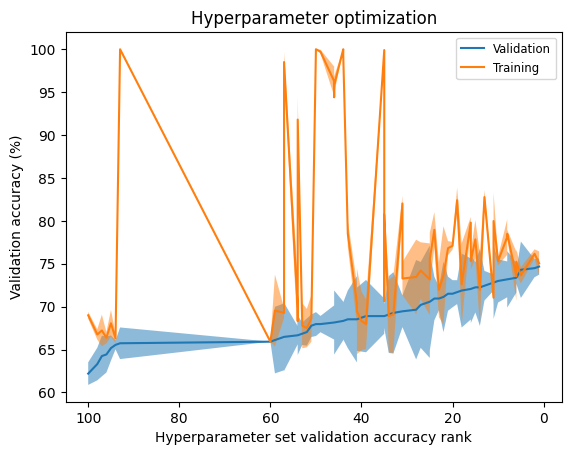

In [28]:
funcs.plot_cross_validation(search_results)

### 4.3. Cross-validation of optimized model

In [29]:
scores = cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Optimized decision tree']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Optimized decision tree cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Optimized decision tree cross-validation accuracy: 73.2 +/- 6.0%


## 5. Evaluation

### 5.1. Model comparison

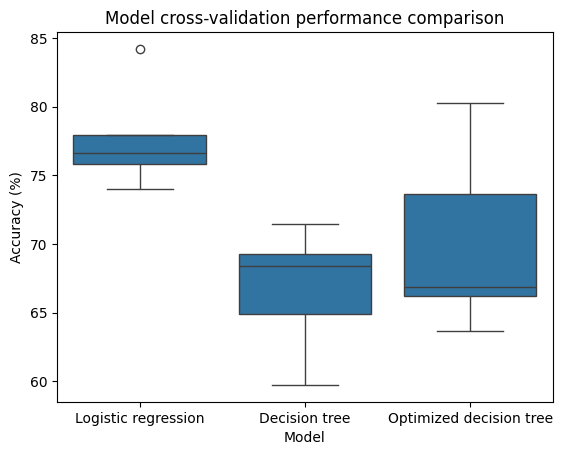

In [30]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

### 5.2. Test set performance

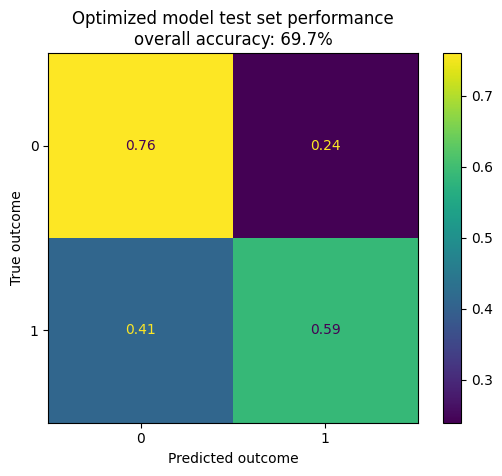

In [31]:
testing_predictions = model.predict(testing_df.drop('Outcome', axis=1))
accuracy = accuracy_score(testing_predictions, testing_df['Outcome'])*100

# Plot the confusion matrix
cm = confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_ = cm_disp.plot()

plt.title(f'Optimized model test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()

## 6. Save

### 6.1. Data

In [ ]:
Path('../data/raw').mkdir(exist_ok=True, parents=True)
data_df.to_parquet(config.RAW_DATA_FILE)

Path('../data/processed').mkdir(exist_ok=True, parents=True)
data = {
    'training': training_df,
    'testing': testing_df
}

with open(config.DATA_FILE, 'wb') as output_file:
    pickle.dump(data, output_file)

### 6.2. Optimized hyperparameters

In [33]:
Path('../models').mkdir(exist_ok=True, parents=True)

with open(config.DECISION_TREE_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(hyperparameters, output_file)

### 6.3. Model

In [34]:
with open(config.DECISION_TREE_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)